<a href="https://colab.research.google.com/github/AlirezaPNouri/Storytelling/blob/main/TF_IDF_Keyword_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this code, TF-IDF technique has been used to extract keywords from a text

In [1]:
import pickle
import re
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer


In [2]:
stopwords = ['i','me','my','myself','we','our','ours','ourselves','you','your','yours','yourself','yourselves','he','him','his','himself','she','her','hers','herself','it','its','itself','they','them','their','theirs','themselves','what','which','who','whom','this','that','these','those','am','is','are','was','were','be','been','being','have','has','had','having','do','does','did','doing','a','an','the','and','but','if','or','because','as','until','while','of','at','by','for','with','about','against','between','into','through','during','before','after','above','below','to','from','up','down','in','out','on','off','over','under','again','further','then','once','here','there','when','where','why','how','all','any','both','each','few','more','most','other','some','such','no','nor','not','only','own','same','so','than','too','very','s','t','can','will','just','don','should','now', 'of', 'within']
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [24]:
df = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/df.p', 'rb'))
story_data = pickle.load(open('drive/MyDrive/temp/data_r/final_results_proposed.p', 'rb'))
df_embedding = pickle.load(open('drive/MyDrive/temp/data_r/Proposed/Embed_dict.p', 'rb'))

In [4]:
def special_char_remover(str_):
  """
  This function removes any special characters from a text
  Arguments:
    str_: a string
  Returns:
    A string
  """
  return ' '.join(''.join(w for w in m if w.isalnum()) for m in str_.split(' '))

In [5]:
def pre_process(text):
    # lowercase
    text = text.lower()
    # remove tags
    text = re.sub("", "", text)
    # remove special characters and digits
    text = re.sub("(\\d|\\W)+", " ", text)
    return text

In [6]:
def stopword_remover(str_, stopwords_):
  words = word_tokenize(str_)
  ps = PorterStemmer()
  temp_list = list()
  for ele in words:
    if ele not in stopwords_:
      temp_list.append(ps.stem(ele))
  return ' '.join(temp_list)



In [7]:
data_content = dict()
for index, row in df.iterrows():
  data_content[row['id']] = stopword_remover(pre_process(special_char_remover(row['content'])), stopwords)


In [8]:
cv = CountVectorizer(max_df=0.85, stop_words=stopwords)

In [9]:
word_count_vector = cv.fit_transform(data_content.values())

In [10]:
# list(cv.vocabulary_.keys())[:10]

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
tfidf_transformer.fit(word_count_vector)

TfidfTransformer()

In [12]:
def sort_coo(coo_matrix):
    tuples = zip(coo_matrix.col, coo_matrix.data)
    return sorted(tuples, key=lambda x: (x[1], x[0]), reverse=True)
def extract_topn_from_vector(feature_names, sorted_items, topn=10):
    """get the feature names and tf-idf score of top n items"""
    
    #use only topn items from vector
    sorted_items = sorted_items[:topn]
    score_vals = []
    feature_vals = []
    
    # word index and corresponding tf-idf score
    for idx, score in sorted_items:
        
        #keep track of feature name and its corresponding score
        score_vals.append(round(score, 3))
        feature_vals.append(feature_names[idx])
    #create a tuples of feature,score
    #results = zip(feature_vals,score_vals)
    results= {}
    for idx in range(len(feature_vals)):
        results[feature_vals[idx]]=score_vals[idx]
    
    return results

In [13]:

# you only needs to do this once, this is a mapping of index to 
feature_names=cv.get_feature_names_out()
top_keywords = dict()
for ind, doc in data_content.items():
  # get the document that we want to extract keywords from
  # doc=data_content[51167]
  #generate tf-idf for the given document
  tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
  #sort the tf-idf vectors by descending order of scores
  sorted_items=sort_coo(tf_idf_vector.tocoo())
  #extract only the top n; n here is 10
  keywords=extract_topn_from_vector(feature_names,sorted_items,20)
  # now print the results
  # print("\n=====Doc=====")
  # print(doc)
  # print("\n===Keywords===")
  temp_list = dict()
  for k, val in keywords.items():
    temp_list[k] = val
        # print(k,keywords[k])
  top_keywords[ind] = temp_list

In [14]:
def jaccard_similarity(text1, text2):
  set_text1 = set(text1)
  set_text2 = set(text2)

  return len(set_text1.intersection(set_text2)) / len(set_text1.union(set_text2))

In [15]:
sampl = story_data[0.25][1]
keyword_story = dict()
for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
  keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())




In [16]:
total_dict = dict()

for total in range(len(story_data[0.25])):
  sampl = story_data[0.25][total]
  keyword_story = dict()
  for doc_1, doc_2 in zip(sampl[:-1], sampl[1:]):
    keyword_story[doc_1] = jaccard_similarity(top_keywords[doc_1].keys(), top_keywords[doc_2].keys())
  total_dict[total] = keyword_story



In [17]:
print(total_dict[4])

{549164: 0.0, 666074: 0.0, 51248: 0.0, 725184: 0.02564102564102564, 200945: 0.0, 51295: 0.0, 774591: 0.0, 51082: 0.0, 600616: 0.0, 106167: 0.0, 656252: 0.0, 551442: 0.0, 731886: 0.0, 738814: 0.02564102564102564, 555096: 0.02564102564102564, 654198: 0.02564102564102564, 85977: 0.0, 165545: 0.0, 142474: 0.0, 549576: 0.05263157894736842, 145579: 0.0, 691871: 0.0, 687244: 0.0, 502870: 0.0}


In [18]:
chan_dict = dict()
for st in total_dict.keys():
  if len(total_dict[st]) > 4:
    chan_dict[st] =sum(list(total_dict[st].values()))
ind = sorted(chan_dict.values())
list_of_stories = list()
# for z in range(len(ind)):
for t, v in chan_dict.items():
  if v == ind[-1]:
    print(t, ' -> ', total_dict[t])
    list_of_stories.append(t)



56  ->  {578750: 0.02564102564102564, 733259: 0.0, 696125: 0.08108108108108109, 757788: 0.05263157894736842, 724837: 0.1111111111111111, 702241: 0.02564102564102564, 67101: 0.05263157894736842, 769272: 0.0, 578579: 0.0, 78378: 0.0, 85585: 0.0, 511458: 0.02564102564102564, 734988: 0.02564102564102564, 50588: 0.0, 106167: 0.0, 656252: 0.0, 551442: 0.0, 731886: 0.0, 738814: 0.02564102564102564, 555096: 0.02564102564102564, 654198: 0.02564102564102564, 85977: 0.0, 165545: 0.0, 142474: 0.0, 549576: 0.05263157894736842, 145579: 0.0, 691871: 0.0, 687244: 0.0, 502870: 0.0}


In [19]:
for story in total_dict[list_of_stories[-1]]:
  print(top_keywords[story].keys())

dict_keys(['lvad', 'inr', 'thrombosi', 'anticoagul', 'patient', 'thrombot', 'covid', 'heartmat', 'infect', 'iqr', 'pump', 'laboratori', 'radiograph', 'median', 'stroke', 'arteri', 'evid', 'failur', 'warfarin', 'thrombogen'])
dict_keys(['donor', 'lung', 'sarscov', 'plex', 'postop', 'bal', 'immunosuppress', 'dsa', 'infect', 'pretranspl', 'ivig', 'amr', 'tacrolimu', 'mycophenol', 'interstiti', 'np', 'mandat', 'preoper', 'sampl', 'case'])
dict_keys(['tertil', 'iqr', 'bmi', 'ecmo', 'kgm', 'ahr', 'mortal', 'oxygen', 'middl', 'inhospit', 'lowest', 'obes', 'patient', 'highest', 'place', 'hospit', 'comparison', 'redcap', 'outcom', 'timetoev'])
dict_keys(['collaps', 'circulatori', 'impella', 'hemodynam', 'lv', 'cardiogen', 'acut', 'manag', 'ecmo', 'shock', 'iabp', 'support', 'inotrop', 'patient', 'fluid', 'recoveri', 'requir', 'day', 'covid', 'place'])
dict_keys(['vaccin', 'johnson', 'patient', 'ht', 'breakthrough', 'infect', 'transplant', 'histori', 'receiv', 'covid', 'nearli', 'st', 'common', 

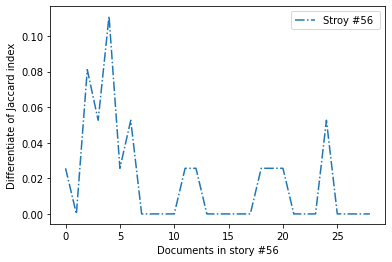

In [34]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
y = list(total_dict[list_of_stories[0]].values())
x = [x for x in range(len(total_dict[list_of_stories[0]].keys()))]
plt.plot(x, y, label = "Stroy #56 ", linestyle="-." )
plt.ylabel('Differentiate of Jaccard index')
plt.xlabel('Documents in story #56')

# y = list(total_dict[1].values())
# x = [x for x in range(len(total_dict[1].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[2].values())
# x = [x for x in range(len(total_dict[2].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[3].values())
# x = [x for x in range(len(total_dict[3].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[4].values())
# x = [x for x in range(len(total_dict[4].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[5].values())
# x = [x for x in range(len(total_dict[5].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

plt.legend()
plt.show()

In [21]:
# list_of_stories[-1] is the best story in the list

word_cloud_frequency = dict()
for story in total_dict[list_of_stories[-1]]:
  story_text = list()
  for word_, freq in top_keywords[story].items():
    for ind in range(int(100*freq)):
      story_text.append(word_)
  word_cloud_frequency[story] = ' '.join(story_text)





---------- 578750 ------------


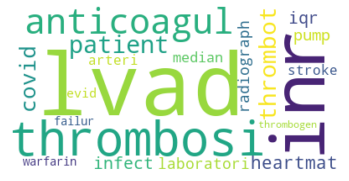


---------- 733259 ------------


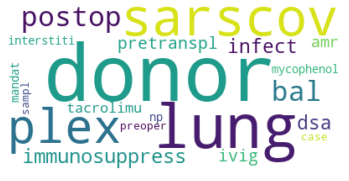


---------- 696125 ------------


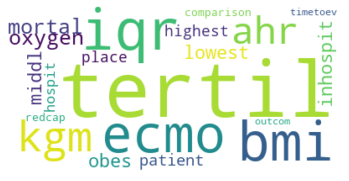


---------- 757788 ------------


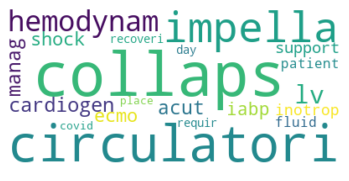


---------- 724837 ------------


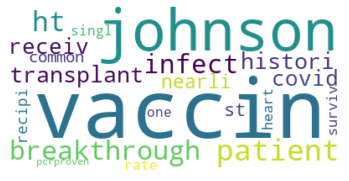


---------- 702241 ------------


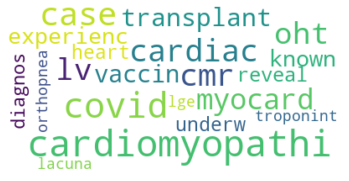


---------- 67101 ------------


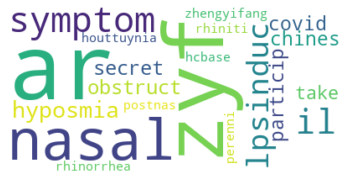


---------- 769272 ------------


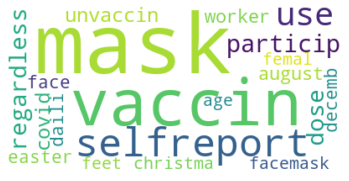


---------- 578579 ------------


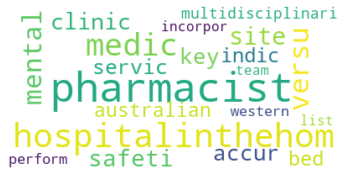


---------- 78378 ------------


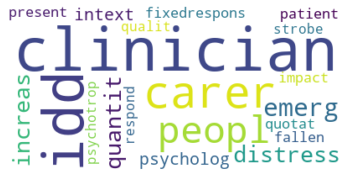


---------- 85585 ------------


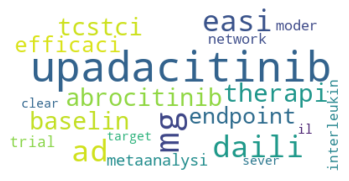


---------- 511458 ------------


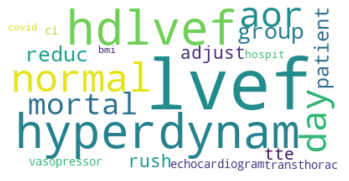


---------- 734988 ------------


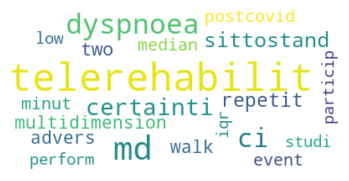


---------- 50588 ------------


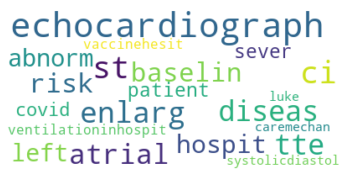


---------- 106167 ------------


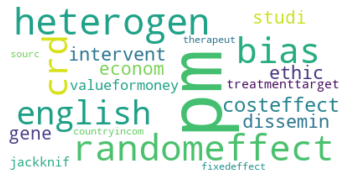


---------- 656252 ------------


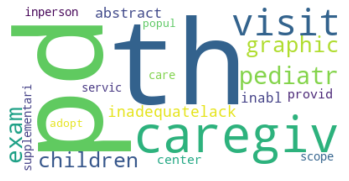


---------- 551442 ------------


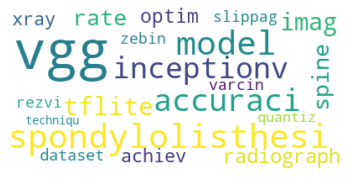


---------- 731886 ------------


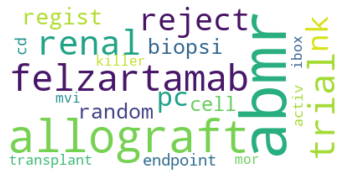


---------- 738814 ------------


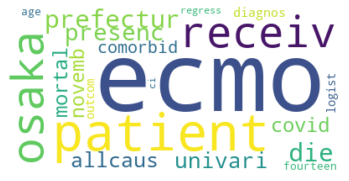


---------- 555096 ------------


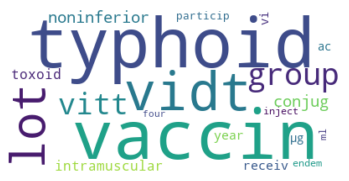


---------- 654198 ------------


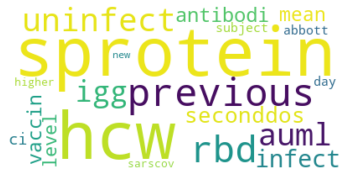


---------- 85977 ------------


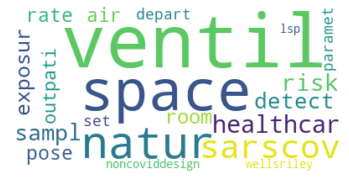


---------- 165545 ------------


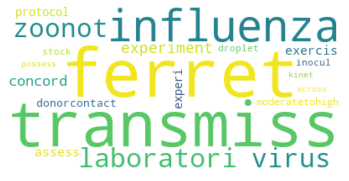


---------- 142474 ------------


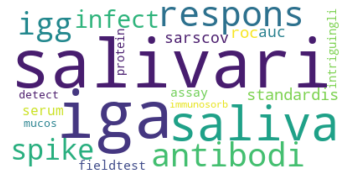


---------- 549576 ------------


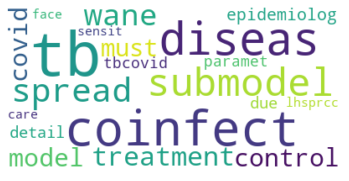


---------- 145579 ------------


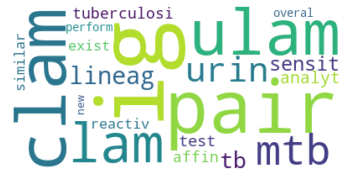


---------- 691871 ------------


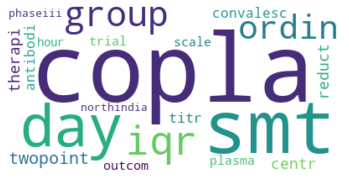


---------- 687244 ------------


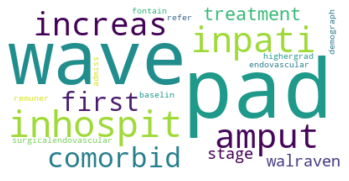


---------- 502870 ------------


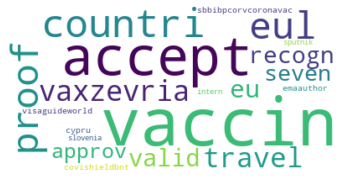

In [22]:
# to plot word cloud
import matplotlib.pyplot as plt
from wordcloud import WordCloud
for story in total_dict[list_of_stories[-1]]:
  word_cloud = WordCloud(collocations = False, background_color = 'white').generate(word_cloud_frequency[story])
  print('---------- {} ------------'.format(story))
  plt.imshow(word_cloud, interpolation='bilinear')
  plt.axis("off")
  plt.show()
  print()

In [29]:
doc_embedding = dict()
for ts_ in df_embedding.keys():
  for doc in df_embedding[ts_].keys():
    doc_embedding[doc] =sum([a*a for a in df_embedding[ts_][doc]['cls']])/728





# for story in total_dict[list_of_stories[-1]]:


In [30]:
embed_astory_list = list()
for story in total_dict[list_of_stories[-1]]:
  embed_ astory_list.append(doc_embedding[story])

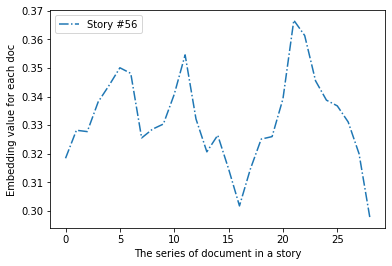

In [32]:
# importing package
import matplotlib.pyplot as plt
import numpy as np
  
# create data
y = list(embed_astory_list)
x = [x for x in range(len(y))]
plt.plot(x, y, label = "Story #56", linestyle="-." )
plt.xlabel('The series of document in a story')
plt.ylabel('Embedding value for each doc')

# y = list(total_dict[1].values())
# x = [x for x in range(len(total_dict[1].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[2].values())
# x = [x for x in range(len(total_dict[2].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[3].values())
# x = [x for x in range(len(total_dict[3].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[4].values())
# x = [x for x in range(len(total_dict[4].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

# y = list(total_dict[5].values())
# x = [x for x in range(len(total_dict[5].keys()))]
# plt.plot(x, y, label = "BERT method ", linestyle="-." )

plt.legend()
plt.show()